In [51]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GroupKFold, cross_validate
from sklearn.gaussian_process.kernels import Matern, RBF

from spe.mse_estimator import ErrorComparer
from spe.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat

import matplotlib.pyplot as plt

## Setup

In [28]:
nx = 50
ny = 50

n = nx * ny
p = 30
s = 30

In [12]:
xs = np.linspace(0, 25, nx)
ys = np.linspace(0, 25, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [13]:
Sigma = gen_cov_mat(c_x, c_y, RBF(length_scale=1.))
Chol = np.linalg.cholesky(Sigma)

## Generate Gaussian X, Y

In [140]:
X = gen_rbf_X(c_x, c_y, p)
# X = gen_matern_X(c_x, c_y, p, length_scale=1, nu=1)
# X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s)
beta[idx] = np.random.uniform(-1,1,size=s)

In [141]:
Y = X@beta + Chol @ np.random.randn(n)

In [142]:
tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
tr_bool = np.zeros(n, dtype=bool)
tr_bool[tr_idx] = True

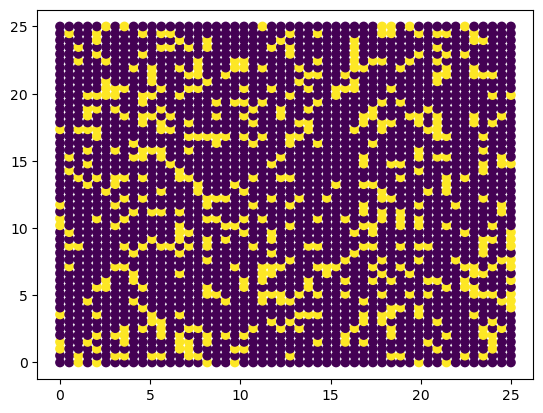

In [143]:
plt.scatter(c_x, c_y, c=tr_bool, label=tr_bool)


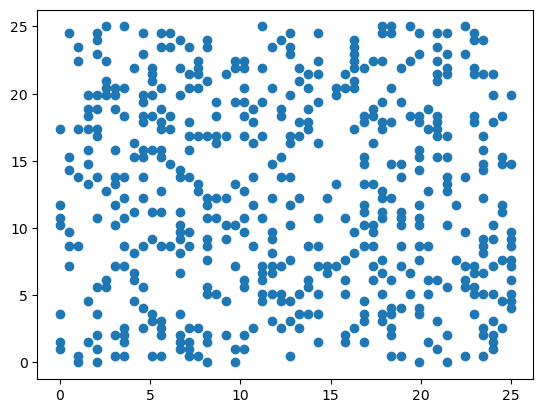

In [144]:
plt.scatter(c_x[tr_bool], c_y[tr_bool])


In [158]:
def kFoldCV(X, y):
    return cross_validate(LinearRegression(), X, y, cv=KFold(n_splits=10, shuffle=True), scoring='neg_mean_squared_error')

def ErrXY(X, y, tr_idx):
    m = LinearRegression()
    m.fit(X[tr_idx], y[tr_idx])
    return np.mean((y[~tr_idx] - m.predict(X[~tr_idx]))**2)

def ErrX(X, beta, Chol, tr_idx, niter=100):
    errs = np.zeros(niter)
    for i in np.arange(niter):
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_idx)
    return np.mean(errs)

def AvgErr(c_x, c_y, p, beta, Chol, niter=100): 
    n = len(c_x)
    errs = np.zeros(niter)
    for i in np.arange(niter):    
        tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True
        
        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_bool)
    return np.mean(errs)

In [159]:
kfcverr = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

In [160]:
errxy = ErrXY(X, Y, tr_bool)

In [161]:
errx = ErrX(X, beta, Chol, tr_bool)

In [163]:
avgerr = AvgErr(c_x, c_y, p, beta, Chol)

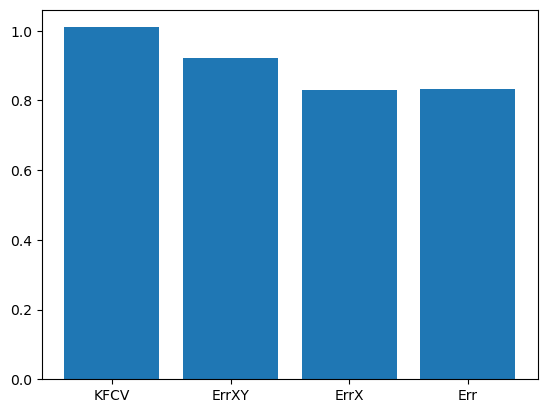

In [164]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(4),height=[kfcverr, errxy, errx, avgerr])
ax.set_xticks(np.arange(4), labels=['KFCV', 'ErrXY', 'ErrX', 'Err'])

In [165]:
[kfcverr, errxy, errx, avgerr]


[1.0099782565576434, 0.9210162805151038, 0.8291285631290977, 0.831812659946038]

In [166]:
def sim(c_x, c_y, n, p, beta, Chol, nsims=100):
    res = np.zeros((4,nsims))
    
    for i in np.arange(nsims):
        if i % 10 == 0: 
            print(i)
            
        tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True

        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        
        res[0,i] = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

        res[3,i] = ErrXY(X, Y, tr_bool)

        res[2,i] = ErrX(X, beta, Chol, tr_bool)

        res[1,i] = AvgErr(c_x, c_y, p, beta, Chol)
        
    return res

In [167]:
res = sim(c_x, c_y, n, p, beta, Chol, 100)

0
10
20
30
40
50
60
70
80
90


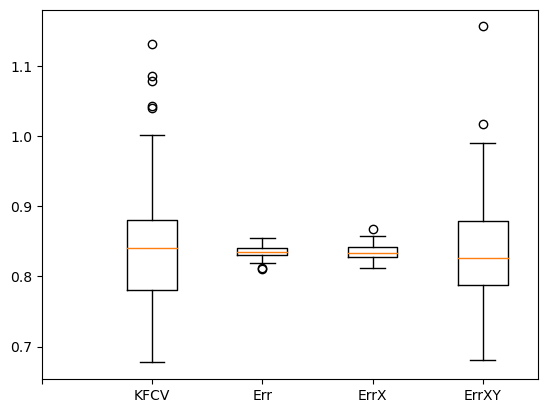

In [168]:
fig, ax = plt.subplots()
ax.boxplot(res.T)
ax.set_xticks(np.arange(5), labels=['', 'KFCV', 'Err', 'ErrX', 'ErrXY'])

In [169]:
res.mean(1)

array([0.84443459, 0.83519266, 0.83498047, 0.8369631 ])

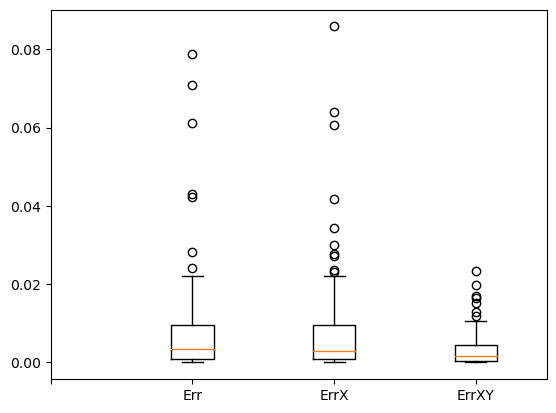

In [170]:
fig, ax = plt.subplots()
ax.boxplot((res[1:,:] - res[0,:]).T**2)
ax.set_xticks(np.arange(4), labels=['', 'Err', 'ErrX', 'ErrXY'])

In [171]:
((res[1:,:] - res[0,:]).T**2).mean(0)

array([0.00815948, 0.00826193, 0.00339082])